In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

In [2]:
%matplotlib inline

## Background

<B>S&P 500 Stock Market Index</B>: The S&P 500 stock market index, maintained by S&P Dow Jones Indices, comprises 505 common stocks issued by 500 large-cap companies and traded on American stock exchanges, and covers about 80 percent of the American equity market by capitalization. The index is weighted by free-float market capitalization, so more valuable companies account for relatively more of the index. The index constituents and the constituent weights are updated regularly using rules published by S&P Dow Jones Indices. Although the index is called the S&P "500", the index contains 505 stocks because it includes two share classes of stock from 5 of its component companies.

## Problem

Predict S&P 500 stock prices for the next minute. The objective is merely to try TensorFlow to build a prediction system, rather than actually build an effective model to predict stock prices, which can be quite complex. 

## Data

The dataset includes roughly 40000 stock data, scraped Google Finance API by an external team. The period of the data ranges between April 2017 to August 2017. Fortunately, the data is already cleaned and prepared. The missing values were imputed using the LOCF (Last-Observation-Carried-Forward) approach.

In [3]:
data = pd.read_csv('inputs/data_stocks.csv')
data.shape

(41266, 502)

In [4]:
data.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


The dataset includes 502 columns, one for each of the 500 companies, one for overall S&P index, and one for the time in minutes interval. We can get rid of the `DATE` column, since only the ordering of the values matter, which is already preserved by the index.

In [5]:
data = data.drop(['DATE'], axis=1)
data.shape

(41266, 501)

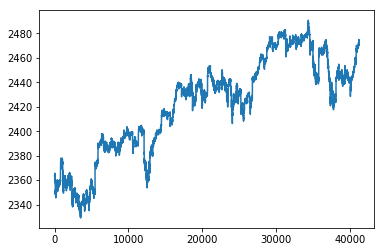

In [6]:
plt.plot(data['SP500'])

### Train-Test split:

Model Testing data: For testing, we will take away last 500 rows (roughly 1%) of the data. 
Model Training: For model training and parameter tuning, we will do cross validation using walk-forward approach, which is suitable for time series validation (See https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection, http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

In [7]:
total_data_length = data.shape[0]
test_data_length = int(total_data_length*0.8)
train_data = data[:total_data_length-test_data_length]
test_data = data[total_data_length-test_data_length:]

In [8]:
train_data.shape, test_data.shape

((8254, 501), (33012, 501))

#### Scaling

In [9]:
def scale_data(train_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled

train_scaled, test_scaled = scale_data(train_data, test_data)

In [10]:
X_train = train_scaled[:, 1:]
Y_train = train_scaled[:, 0]
X_test = test_scaled[:, 1:]
Y_test = test_scaled[:, 0]

#### Network Creation

In [11]:
num_features = 500
X = tf.placeholder(dtype=tf.float32, shape=[None, num_features])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [12]:
# initializers
weight_initializer = tf.variance_scaling_initializer(mode='fan_avg', distribution='uniform', scale=1)
bias_initializer = tf.zeros_initializer()

In [13]:
# weights and biases
# Layer 1
num_neurons_1 = 1024
weights_1 = tf.Variable(weight_initializer([num_features, num_neurons_1]))
bias_1 = tf.Variable(bias_initializer([num_neurons_1]))

# Layer 2
num_neurons_2 = 512
weights_2 = tf.Variable(weight_initializer([num_neurons_1, num_neurons_2]))
bias_2 = tf.Variable(bias_initializer([num_neurons_2]))

# Layer 3
num_neurons_3 = 268
weights_3 = tf.Variable(weight_initializer([num_neurons_2, num_neurons_3]))
bias_3 = tf.Variable(bias_initializer([num_neurons_3]))

# Layer 4
num_neurons_4 = 128
weights_4 = tf.Variable(weight_initializer([num_neurons_3, num_neurons_4]))
bias_4 = tf.Variable(bias_initializer([num_neurons_4]))

# Final Layer 5
num_targets = 1
weights_target = tf.Variable(weight_initializer([num_neurons_4, num_targets]))
bias_target = tf.Variable(bias_initializer([num_targets]))

In [14]:
# layer design
layer_1 = tf.nn.relu(tf.add(tf.matmul(X, weights_1), bias_1))
layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights_2), bias_2))
layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights_3), bias_3))
layer_4 = tf.nn.relu(tf.add(tf.matmul(layer_3, weights_4), bias_4))
layer_target = tf.transpose(tf.add(tf.matmul(layer_4, weights_target), bias_target))

In [15]:
# cost function
cost = tf.reduce_mean(tf.squared_difference(layer_target, Y))

In [16]:
# optimizer
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [17]:
# session
session = tf.InteractiveSession()

# initialize
session.run(tf.global_variables_initializer())

In [22]:
batch_size = 256
num_epochs = 10
cost_train = []
cost_test = []

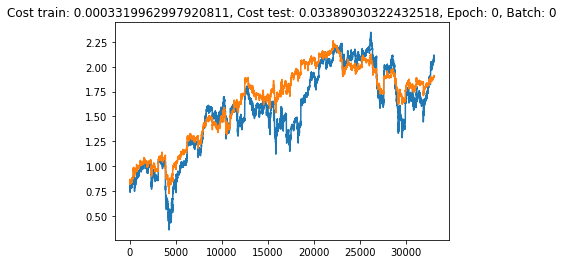

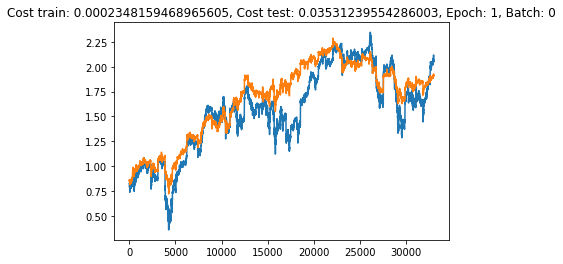

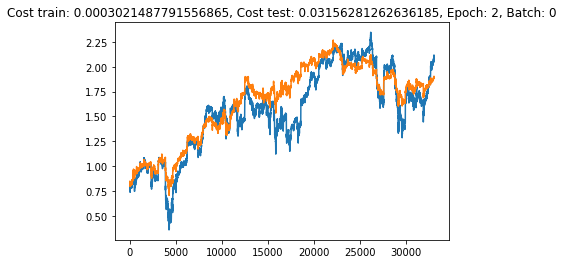

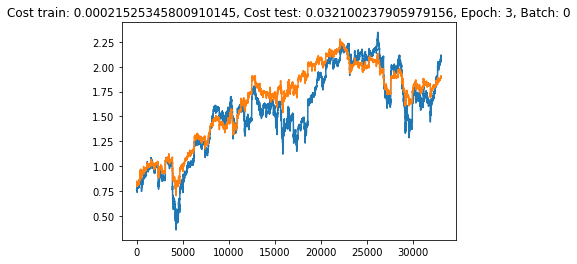

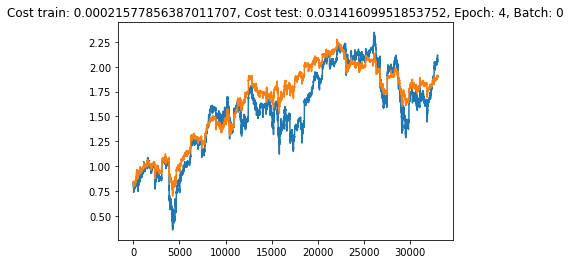

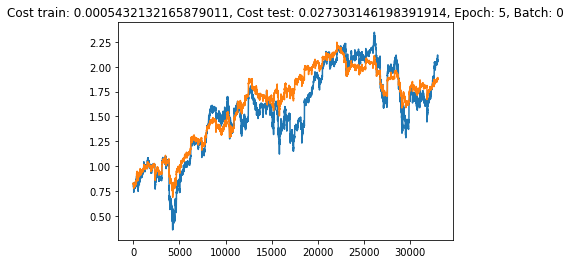

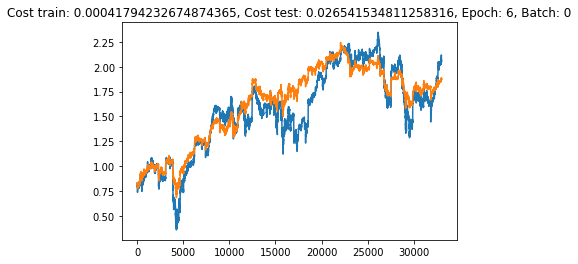

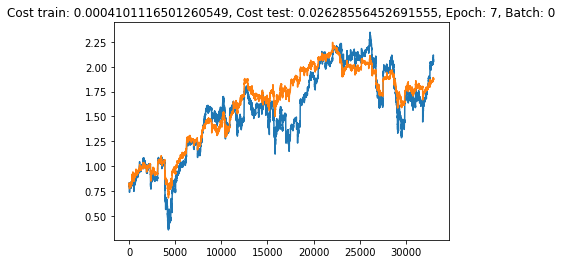

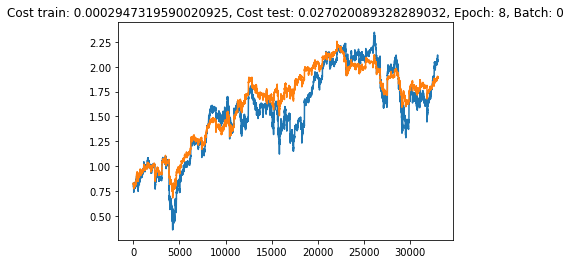

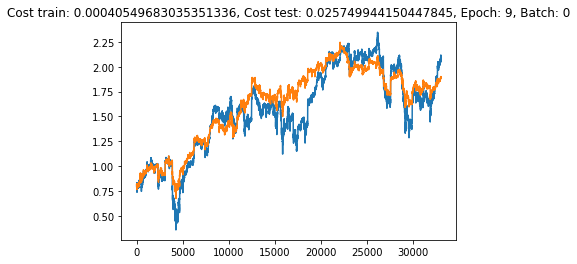

In [23]:
for epoch in range(num_epochs):
    for batch in range(0, len(Y_train)//batch_size):
        start = batch * batch_size
        X_batch = X_train[start: start + batch_size]
        Y_batch = Y_train[start: start + batch_size]
        
        session.run(optimizer, feed_dict={X: X_batch, Y: Y_batch})
        
        if np.mod(batch, 128) == 0:
            train_result = session.run(cost, feed_dict={X: X_train, Y: Y_train})
            test_result = session.run(cost, feed_dict={X: X_test, Y: Y_test})
            cost_train.append(train_result)
            cost_test.append(test_result)
            
            prediction = session.run(layer_target, feed_dict={X: X_test})
            fig = plt.figure()
            axis = fig.add_subplot(111)
            axis.plot(Y_test)
            axis.plot(prediction[0])
            plt.title('Cost train: {}, Cost test: {}, Epoch: {}, Batch: {}'.format(train_result, 
                                                                                  test_result, 
                                                                                  epoch, 
                                                                                  batch))
            plt.show()
            print ()
        

In [ ]:
cost